<a href="https://colab.research.google.com/github/ngyoozheng-2025/Organ-C-Codefest-Hackathon/blob/main/OrganC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"wulifla","key":"8cb2b64dfb5c54debe54f486823b3ebd"}'}

In [4]:
import pandas as pd
import numpy as np
from prophet import Prophet
from sklearn.ensemble import IsolationForest, RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.multioutput import MultiOutputClassifier
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import joblib
import shap
import os

In [5]:
!pip install kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [6]:
!kaggle kernels output aslanahmedov/walmart-sales-forecasting -p /content/walmart_output

Output file downloaded to /content/walmart_output/clean_data.csv
Kernel log downloaded to /content/walmart_output/walmart-sales-forecasting.log 


In [7]:
os.listdir('/content/walmart_output')

['walmart-sales-forecasting.log', 'clean_data.csv']

In [8]:
# Install necessary libraries
!pip install prophet scikit-learn pandas numpy matplotlib joblib

In [9]:
# Load cleaned CSV from Kaggle kernel output
data_path = '/content/walmart_output/clean_data.csv'
df = pd.read_csv(data_path)

# Drop unnamed index column if exists
if 'Unnamed: 0' in df.columns:
    df = df.drop(columns=['Unnamed: 0'])

print("Data shape:", df.shape)
print(df.columns)
df.head()

Data shape: (420212, 23)
Index(['Store', 'Dept', 'Date', 'Weekly_Sales', 'IsHoliday', 'Temperature',
       'Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4',
       'MarkDown5', 'CPI', 'Unemployment', 'Type', 'Size', 'Super_Bowl',
       'Labor_Day', 'Thanksgiving', 'Christmas', 'week', 'month', 'year'],
      dtype='object')


,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,...,Unemployment,Type,Size,Super_Bowl,Labor_Day,Thanksgiving,Christmas,week,month,year
0,1,1,2010-02-05,24924.50,False,42.31,2.572,0.0,0.0,0.0,...,8.106,A,151315,False,False,False,False,5,2,2010
1,1,2,2010-02-05,50605.27,False,42.31,2.572,0.0,0.0,0.0,...,8.106,A,151315,False,False,False,False,5,2,2010
2,1,3,2010-02-05,13740.12,False,42.31,2.572,0.0,0.0,0.0,...,8.106,A,151315,False,False,False,False,5,2,2010
3,1,4,2010-02-05,39954.04,False,42.31,2.572,0.0,0.0,0.0,...,8.106,A,151315,False,False,False,False,5,2,2010
4,1,5,2010-02-05,32229.38,False,42.31,2.572,0.0,0.0,0.0,...,8.106,A,151315,False,False,False,False,5,2,2010


In [20]:

# Convert Date to datetime and sort
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')

# Fill missing MarkDowns with 0
markdown_cols = [col for col in df.columns if 'MarkDown' in col]
df[markdown_cols] = df[markdown_cols].fillna(0)

# Fill numeric columns with median
numeric_cols_fill = ['Temperature', 'Fuel_Price', 'CPI', 'Unemployment']
for col in numeric_cols_fill:
    if col in df.columns:
        df[col] = df[col].fillna(df[col].median())

sales_by_date = df.groupby('Date')['Weekly_Sales'].sum().reset_index()
sales_by_date.rename(columns={'Date':'ds','Weekly_Sales':'y'}, inplace=True)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


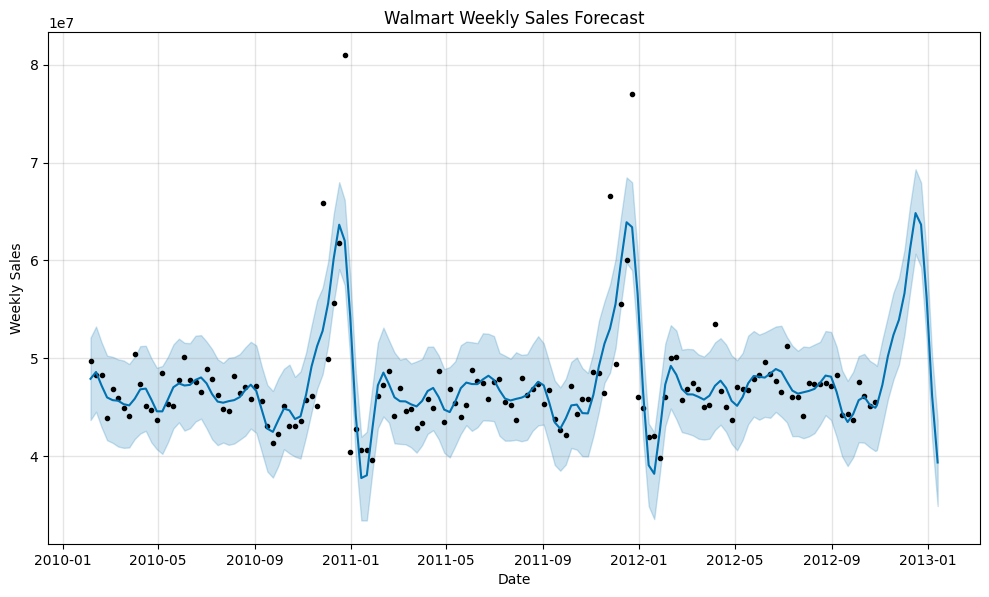

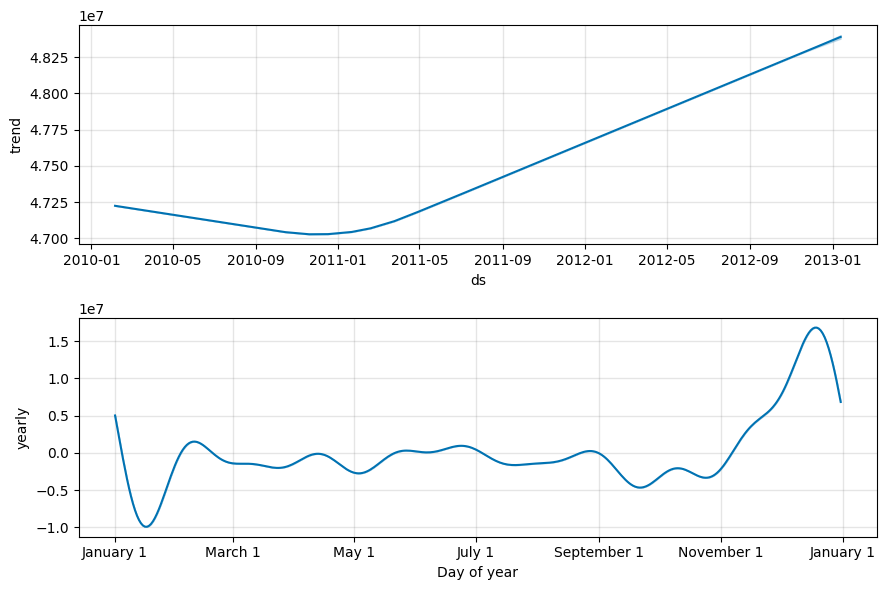

In [11]:
model_prophet = Prophet()
# Optional holidays (uncomment if you want to include)
# holidays = pd.DataFrame({
#     'holiday': ['Super_Bowl','Labor_Day','Thanksgiving','Christmas'],
#     'ds': pd.to_datetime(['2010-02-07','2010-09-06','2010-11-26','2010-12-31']),
#     'lower_window': 0, 'upper_window': 1
# })
# model_prophet = Prophet(holidays=holidays)

# Fit and forecast
model_prophet.fit(sales_by_date)
future = model_prophet.make_future_dataframe(periods=12, freq='W')
forecast = model_prophet.predict(future)

# Plot
model_prophet.plot(forecast)
plt.title("Walmart Weekly Sales Forecast")
plt.xlabel("Date")
plt.ylabel("Weekly Sales")
plt.show()
model_prophet.plot_components(forecast)
plt.show()

In [12]:
# Save model
joblib.dump(model_prophet, 'forecast_model.pkl')

['forecast_model.pkl']

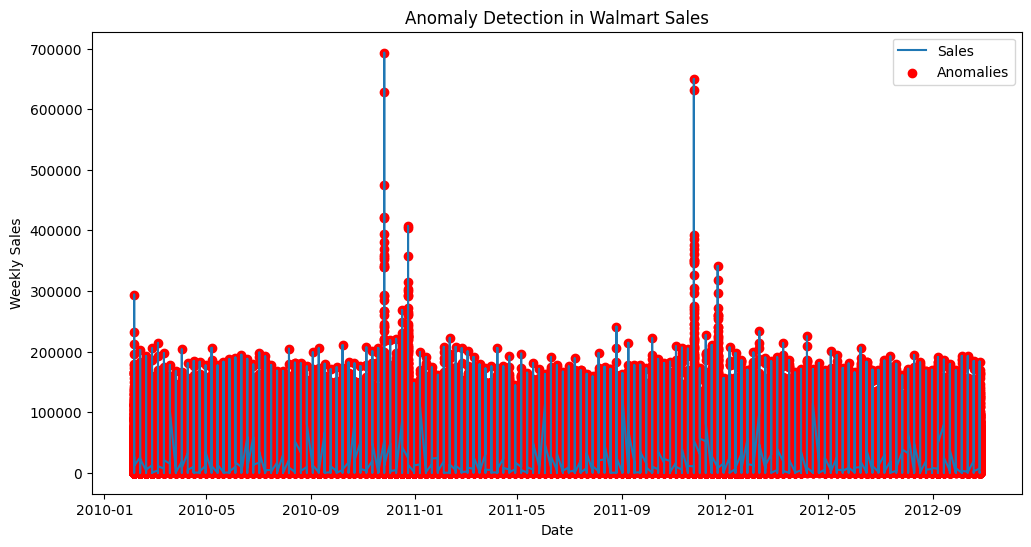

In [13]:
# Select numeric features excluding MarkDowns
numeric_cols = df.select_dtypes(include='number').columns.tolist()
numeric_cols = [c for c in numeric_cols if 'MarkDown' not in c]

# Holiday columns
holiday_cols = ['Super_Bowl','Labor_Day','Thanksgiving','Christmas']
for c in holiday_cols:
    if c in df.columns:
        df[c] = df[c].astype(int)

# Features
feature_cols = numeric_cols + [c for c in holiday_cols if c in df.columns]
X = df[feature_cols].fillna(df[feature_cols].median())

# Scale
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Fit IsolationForest
iso = IsolationForest(random_state=42)
iso.fit(X_scaled)

# Predict anomalies
df['anomaly_score'] = iso.decision_function(X_scaled)
df['anomaly_label'] = iso.predict(X_scaled)  # -1 = anomaly

# Visualize anomalies
anomalies = df[df['anomaly_label']==-1]
plt.figure(figsize=(12,6))
plt.plot(df['Date'], df['Weekly_Sales'], label='Sales')
plt.scatter(anomalies['Date'], anomalies['Weekly_Sales'], color='red', label='Anomalies')
plt.title("Anomaly Detection in Walmart Sales")
plt.xlabel("Date")
plt.ylabel("Weekly Sales")
plt.legend()
plt.show()

In [16]:
# Save model
joblib.dump(iso, 'iso_model.pkl')

['iso_model.pkl']

In [19]:
# Actions
ACTIONS = [
    "increase_staff","decrease_staff","reallocate_staff",
    "open_more_checkouts","extend_hours",
    "increase_local_stock","transfer_stock","expedite_supplier",
    "reduce_reorders","run_promotion","flash_sale",
    "adjust_price_up","adjust_price_down","bundle_offers",
    "local_marketing","push_online_promos","loyalty_incentive",
    "increase_delivery_capacity","offer_curbside","supplier_coordination",
    "investigate_pos","inventory_audit","flag_manager_review"
]

# Heuristic scoring
def heuristic_scores(row, df_ref):
    scores = dict.fromkeys(ACTIONS, 0.0)
    sales = row['Weekly_Sales']
    sales_q90 = df_ref['Weekly_Sales'].quantile(0.90)
    sales_q10 = df_ref['Weekly_Sales'].quantile(0.10)
    sales_m = df_ref['Weekly_Sales'].mean()
    fp = row.get('Fuel_Price', df_ref['Fuel_Price'].median())
    temp = row.get('Temperature', df_ref['Temperature'].median())
    unemp = row.get('Unemployment', df_ref['Unemployment'].median())
    cpi = row.get('CPI', df_ref['CPI'].median())
    is_holiday = int(row.get('IsHoliday', 0))

    # Staffing heuristics
    if is_holiday and sales > sales_m:
        scores['increase_staff'] = 0.9
    if sales > sales_q90:
        scores['increase_staff'] = max(scores['increase_staff'], 0.8)
        scores['open_more_checkouts'] = 0.6
    if sales < sales_q10:
        scores['decrease_staff'] = 0.6

    if 'Dept' in row.index and 'Store' in row.index:
        store_mask = df_ref['Store'] == row['Store']
        dept_mean = df_ref[store_mask & (df_ref['Dept'] == row['Dept'])]['Weekly_Sales'].mean()
        store_mean = df_ref[store_mask]['Weekly_Sales'].mean()
        if pd.notnull(dept_mean) and dept_mean > 1.5 * store_mean:
            scores['reallocate_staff'] = 0.7

    # Inventory
    if sales > sales_q90:
        scores['increase_local_stock'] = 0.85
        scores['transfer_stock'] = 0.6
    if sales < sales_q10:
        scores['reduce_reorders'] = 0.6
        scores['run_promotion'] = 0.55

    # Price/promotions
    if fp > df_ref['Fuel_Price'].quantile(0.9) and sales < sales_m:
        scores['run_promotion'] = 0.7
        scores['adjust_price_down'] = 0.6
    if cpi > df_ref['CPI'].mean() and sales < sales_m:
        scores['run_promotion'] = max(scores['run_promotion'], 0.5)

    # Weather
    if temp > df_ref['Temperature'].mean() + df_ref['Temperature'].std() and sales < sales_m:
        scores['run_promotion'] = 0.6

    # Logistics
    if sales > sales_q90 and is_holiday:
        scores['increase_delivery_capacity'] = 0.6
        scores['offer_curbside'] = 0.5

    # Investigations
    if (sales > df_ref['Weekly_Sales'].quantile(0.995)
        and not is_holiday
        and fp < df_ref['Fuel_Price'].quantile(0.75)):
        scores['investigate_pos'] = 0.9
        scores['inventory_audit'] = 0.7

    # Manager review
    if abs(row['anomaly_score']) > 0.05:
        scores['flag_manager_review'] = 0.4

    # Marketing
    if unemp > df_ref['Unemployment'].mean() and sales < sales_m:
        scores['loyalty_incentive'] = 0.6
        scores['local_marketing'] = 0.5

    # Clamp values
    for k in scores:
        scores[k] = float(min(1.0, max(0.0, scores[k])))

    return scores


soft_labels = []
for idx, row in df.iterrows():
    if row.get('anomaly_label', 1) == -1:
        scores = heuristic_scores(row, df)
    else:
        scores = {a: 0.02 for a in ACTIONS}
    soft_labels.append([scores[a] for a in ACTIONS])

Y_soft = np.array(soft_labels)
Y_bin = (Y_soft >= 0.35).astype(int)


# Train model
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, Y_bin, test_size=0.2, random_state=42
)

clf = MultiOutputClassifier(
    RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)
)

clf.fit(X_train, y_train)


MultiOutputClassifier(estimator=RandomForestClassifier(n_estimators=200,
                                                       n_jobs=-1,
                                                       random_state=42))

In [23]:
# Save the trained heuristic MultiOutputClassifier
joblib.dump(clf, 'walmart_heuristic_model.pkl')

['walmart_heuristic_model.pkl']

In [24]:
# Save the scaler used to generate X_scaled
joblib.dump(scaler, 'walmart_scaler.pkl')

['walmart_scaler.pkl']

In [78]:
# ------------------------
# 1) Load model and scaler
# ------------------------
clf = joblib.load('walmart_heuristic_model.pkl')
scaler = joblib.load('walmart_scaler.pkl')

# ------------------------
# 2) Scale features
# ------------------------
X_scaled = scaler.transform(X)

# ------------------------
# 3) Precompute stats
# ------------------------
sales_q90 = df['Weekly_Sales'].quantile(0.90)
sales_q10 = df['Weekly_Sales'].quantile(0.10)
fuel_p_q90 = df['Fuel_Price'].quantile(0.90)
fuel_p_med = df['Fuel_Price'].median()
temp_mean = df['Temperature'].mean()
temp_std = df['Temperature'].std()
cpi_mean = df['CPI'].mean()
unemp_mean = df['Unemployment'].mean()

# ------------------------
# 4) Only anomaly rows
# ------------------------
anomaly_rows = df[df['anomaly_label'] == -1]

# ------------------------
# 5) Reason → Action map
# ------------------------
reason_to_action = {
    "High weekly sales": ["increase staff", "open more checkouts", "increase local stock"],
    "Low weekly sales": ["run promotion", "reduce reorders", "loyalty incentive"],
    "Holiday period": ["increase staff", "open more checkouts", "increase local stock"],
    "High fuel price": ["adjust price down", "push online promos"],
    "High temperature": ["offer curbside", "increase delivery capacity"],
    "CPI is high": ["run promotion", "bundle offers"],
    "High unemployment": ["local marketing", "loyalty incentive"],
    "Anomaly detected": ["investigate POS", "inventory audit", "flag manager review"]
}

# ------------------------
# 6) Build rows
# ------------------------
rows = []

for original_index, row in anomaly_rows.iterrows():

    reasons = []
    if row['Weekly_Sales'] > sales_q90:
        reasons.append("High weekly sales")
    elif row['Weekly_Sales'] < sales_q10:
        reasons.append("Low weekly sales")
    if row.get('IsHoliday', 0):
        reasons.append("Holiday period")
    if abs(row.get('anomaly_score', 0)) > 0.05:
        reasons.append("Anomaly detected")
    if row['Fuel_Price'] > fuel_p_q90:
        reasons.append("High fuel price")
    if row['Temperature'] > temp_mean + temp_std:
        reasons.append("High temperature")
    if row['Unemployment'] > unemp_mean:
        reasons.append("High unemployment")

    # Create actions
    actions = []
    for r in reasons:
        actions.extend(reason_to_action.get(r, []))
    actions = list(dict.fromkeys(actions))

    # Only keep rows with actions
    if actions:
        sentence = f"Solutions: {', '.join(actions)}; Reasons: {', '.join(reasons)}"
        rows.append({
            "Original Index": original_index,
            "Optimization Solution": sentence
        })

# ------------------------
# 7) Final table sorted by TRUE original CSV index
# ------------------------
results_df = pd.DataFrame(rows)

results_df = results_df.sort_values(
    "Original Index",
    ascending=True     # change to False for descending
).reset_index(drop=True)

display(results_df)

,Original Index,Optimization Solution
0,0,"Solutions: local marketing, loyalty incentive;..."
1,1,"Solutions: increase staff, open more checkouts..."
2,2,"Solutions: local marketing, loyalty incentive;..."
3,3,"Solutions: local marketing, loyalty incentive;..."
4,4,"Solutions: local marketing, loyalty incentive;..."
...,...,...
73979,420142,"Solutions: increase staff, open more checkouts..."
73980,420146,"Solutions: local marketing, loyalty incentive;..."
73981,420152,"Solutions: local marketing, loyalty incentive;..."
73982,420206,"Solutions: increase staff, open more checkouts..."
